## Model Layer Visualization
Implementation of the visual explanation algorithm Grad-CAM adopted from Daniel Reiff's [blog post](https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353).  We wanted to visualize what the final model sees as it classifies the wafermaps and understand why it makes mistakes.

In [2]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models, losses, optimizers, regularizers, callbacks, Input, Model, Sequential

import os
import time
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

import cv2
from skimage.transform import resize as sk_resize
from skimage.util import img_as_ubyte
from skimage.morphology import skeletonize, thin

# !pip install pickle5
import pickle5 as pickle

import boto3
s3 = boto3.resource('s3')
bucket_name = 'wafer-capstone'
my_bucket = s3.Bucket(bucket_name)

import helpers as helper
from keras_model_s3_wrapper import *
from gradcam import *

In [3]:
tf.__version__

'2.3.4'

In [4]:
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load the data

In [5]:
# load data directly from S3 (using boto3 resource)
start = time.time()

data_key = 'processed_data/customer/MixedWM38-single.pkl'
data = pickle.loads(my_bucket.Object(data_key).get()['Body'].read())

print("Wall time: {:.2f} seconds".format(time.time() - start))
print(f"Dataset length: {len(data)}")
data.head()

Wall time: 0.43 seconds
Dataset length: 8015


,ID,waferMap,labels,label_total,failureType,detectLabels,classifyLabels
0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 0, 0, 0, 0]",1,Center,1,2
1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 0, 0, 0, 0]",1,Center,1,2
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 0, 0, 0, 0]",1,Center,1,2
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 0, 0, 0, 0]",1,Center,1,2
4,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 0, 0, 0, 0]",1,Center,1,2


##### Append model predictions

In [9]:
# load predictions
predictions_path = 'final-model-mixedwm38.pkl'
with open(predictions_path, "rb") as fh:
    predictions = pickle.load(fh)

# unpack predictions
probs = predictions[0]
labels = predictions[1]

max_probs = [max(x)*100 for x in probs]

# add columns to dataframe
data['pred_labels'] = labels
data['pred_prob'] = max_probs

print(data.shape)
data.head()

(8015, 9)


,ID,waferMap,labels,label_total,failureType,detectLabels,classifyLabels,pred_labels,pred_prob
0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 0, 0, 0, 0]",1,Center,1,2,0,94.724762
1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 0, 0, 0, 0]",1,Center,1,2,2,52.117580
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 0, 0, 0, 0]",1,Center,1,2,0,92.960232
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 0, 0, 0, 0]",1,Center,1,2,2,93.457317
4,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 0, 0, 0, 0]",1,Center,1,2,2,99.679238


##### Find good and bad examples to plot
**Good** examples are samples where the model predicted the right label with high probability. These will show us what the model sees as a typical example of each defect class.

**Bad** examples are samples where the model predicted the wrong label with high probability. These will give us a glimpse into what the model sees when it makes a mistake.

In [ ]:
# # find good and bad indices
# import random

# defects = [i for i in range(len(data)) if (data.failureType.loc[i] == 'Near-full' and data.pred_labels.loc[i] == 6 and data.pred_prob.loc[i] > 97)]
# print(len(defects))
# random_n = random.sample(defects, 1)
# random_n

In [ ]:
# plt.imshow(data.waferMap[6997])

In [13]:
# good and bad examples
good_indices = [4238, 2885, 752, 3481, 7979, 5151, 6997, 1483, 6661]
bad_indices = [4408, 2862, 736, 0, 7821, 5642, 6978, 1066, 0]

# label lists
true_labels = ['Loc', 'Edge-Loc', 'Center', 'Edge-Ring', 'Scratch', 'Random', 'Near-Full', 'Donut', 'None']
bad_labels = ['Edge-Loc', 'Edge-Ring', 'Loc', '---', 'None', 'Edge-Loc', 'Random', 'Center', '---']

### Load the model
Load the model weights from S3 and rebuild the model to remove the data augmentation (random flips and rotations) used during training.

In [7]:
# load model weights from S3
model_key = 'models/wafermap_final_model.h5'
model_obj = my_bucket.Object(model_key).get()['Body'].read()
loaded_model = s3_get_h5_model(model_obj)
weights = loaded_model.get_weights()

In [8]:
# rebuild model

inputs = Input(shape=(224, 224, 1))
x = layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(3)(x)

x = layers.Flatten()(x)
x = layers.Dense(4096, activation='sigmoid', kernel_regularizer=regularizers.l2(0.000001))(x)
x = layers.Dense(1024, activation='sigmoid', kernel_regularizer=regularizers.l2(0.000001))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(9, activation='softmax')(x)

classify = Model(inputs=inputs, outputs=outputs)

classify.set_weights(weights)

classify.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 74, 74, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)       

### Grad-CAM Plots

In [6]:
# data preprocessing functions

# resize to 224x224
def resize(x):
    y = sk_resize(x, [224,224])
    new_y = img_as_ubyte(y)
    return new_y

# resize to 224x224 --> binarize --> apply n=2 morphological thinning
def preprocess(x):
    y = sk_resize(x, [224,224])
    new_y = img_as_ubyte(y)
    ret, thresh_img = cv2.threshold(new_y, 1, 1, cv2.THRESH_BINARY)
    thin_img = thin(thresh_img, 2)
    return thin_img

# layer to visualize
layer_name = 'conv2d_6'

#### Good Examples
Plots of the wafermaps of the good examples

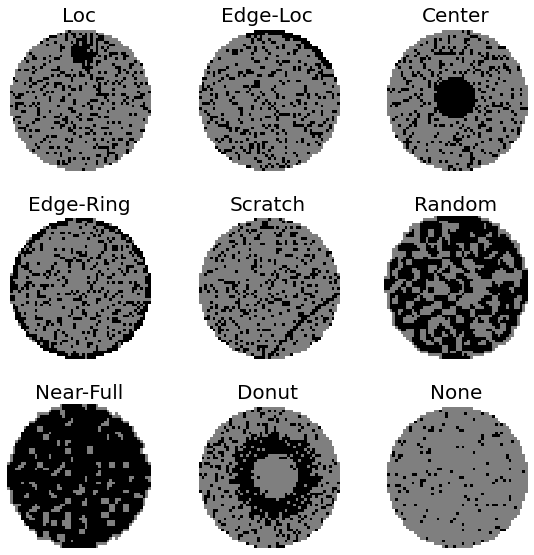

In [11]:
# plot good wafers
good_imgs = [data.waferMap[i] for i in good_indices]
plot_wafers(good_imgs, true_labels, cmap='gray_r')

#### Grad-CAM of good examples
Visualization of the last convolutional layer for the good examples. These images indicate how well the model identifies the defect patterns for these wafers.

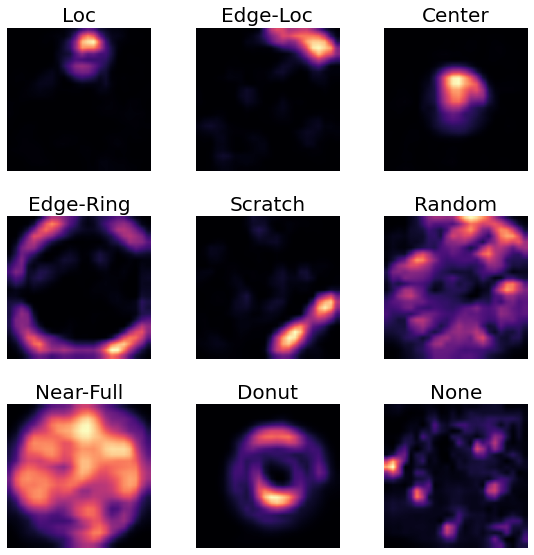

In [14]:
# plot grad-cams of good wafers
good_thin = [preprocess(data.waferMap[i]) for i in good_indices]
good_gcs = [GradCam(classify, good_thin[i], layer_name) for i in range(9)]
plot_wafers(good_gcs, true_labels, cmap='magma')

#### Bad Examples
Plots of the wafermaps of the bad examples. There are no samples for Edge-Ring and None because none from either class was misclassified by the model.

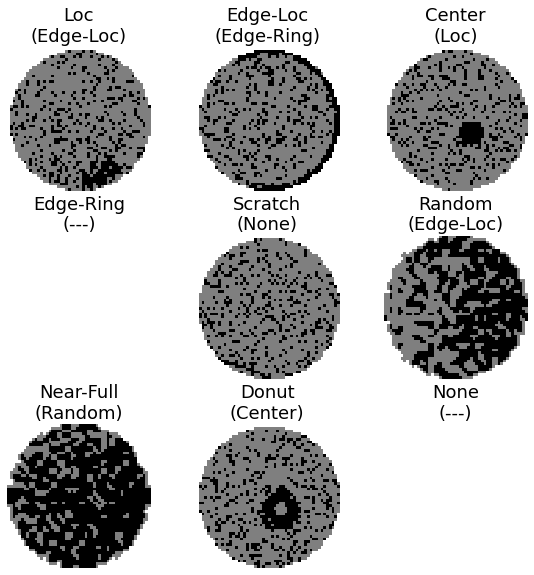

In [15]:
# plot bad wafers
bad_imgs = [data.waferMap[i] if i > 0 else np.zeros((224,224)) for i in bad_indices]
plot_wafers(bad_imgs, true_labels, bad_labels, cmap='gray_r')

#### Grad-CAM of bad examples
Visualization of the last convolutional layer for the bad examples. These images allow us to understand how the model can misclassify these samples.

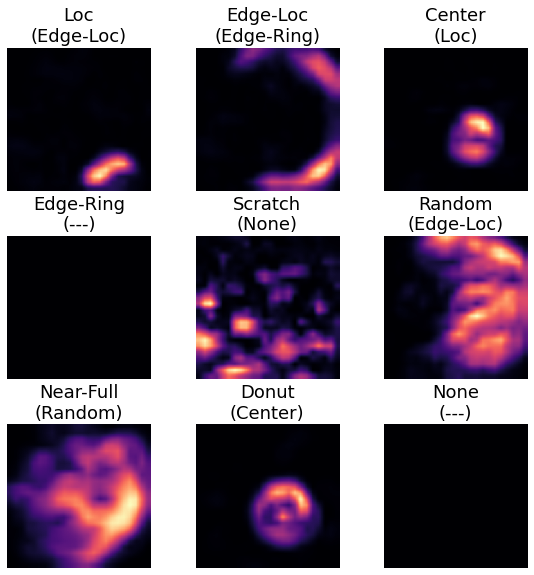

In [16]:
# plot grad-cams of bad wafers
bad_thin = [preprocess(data.waferMap[i]) if i > 0 else np.zeros((224,224)) for i in bad_indices]
bad_gcs = []
for i in range(9):
    if i == 3 or i == 8:
        bad_gcs.append(np.zeros((224,224)))
    else:
        grad_cam=GradCam(classify, bad_thin[i], layer_name)
        bad_gcs.append(grad_cam)
plot_wafers(bad_gcs, true_labels, bad_labels, cmap='magma')

### Superimposed
Grad-CAM images superimposed on the original wafermaps for the good examples.

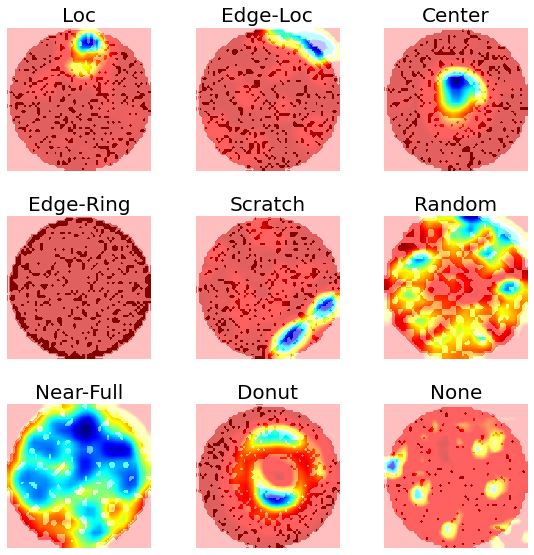

In [17]:
good_224 = [resize(data.waferMap[i]) for i in good_indices]
good_img_bgrs = [generate_img_bgr(good_224[i], binary=False) for i in range(9)]
good_superimposed = [superimpose(good_img_bgrs[i], good_gcs[i], emphasize=False, img_wt=0.75, heatmap_wt=1) for i in range(9)]
plot_wafers(good_superimposed, true_labels, cmap='magma')